### 1. The Swap Test

The swap test is a procedure in quantum computation that is used to check how much two quantum states differ, see [wikipedia](https://en.wikipedia.org/wiki/Swap_test) for more information.

<img src="Image/Quantum-swap-test-circuit-correct.png" width=400 />



**Explanation of the circuit:**

Consider two states: $|\phi\rangle$ and $|\psi\rangle$. 
The state of the system at the beginning of the protocol is $|0,\phi,\psi\rangle$. 
 - After the Hadamard gate, the state  is $\frac{1}{\sqrt{2}}(|0,\phi,\psi\rangle +|1,\phi,\psi\rangle)$
 - After the controlled SWAP gate: $\frac{1}{\sqrt{2}}(|0,\phi,\psi\rangle +|1,\psi,\phi\rangle)$
 - After the second Hadamard gate results in: $
\frac{1}{2}(|0,\phi,\psi\rangle +|1,\phi,\psi\rangle +|0,\psi,\phi\rangle -|1,\psi,\phi\rangle) = \frac{1}{2}|0\rangle (|\phi,\psi\rangle +|\psi,\phi\rangle) +\frac{1}{2}|1\rangle (|\phi,\psi\rangle -|\psi,\phi\rangle)$

The measurement gate on the first qubit ensures that it's 0 with a probability of: $
P(\text{First qubit}=0) = \frac{1}{2}\left(\langle\phi|\langle\psi|+\langle\psi|\langle\phi|\right)\frac{1}{2}\left(|\phi\rangle|\psi\rangle +|\psi\rangle|\phi\rangle\right) = \frac{1}{2}+\frac{1}{2}|\langle\psi|\phi\rangle|^2 $


If $|\psi\rangle$ and $|\phi\rangle$ are orthogonal ($|\langle\psi|\phi\rangle|^2 = 0$), then the probability that 0 is measured is $\frac{1}{2}$.
 If the states are equal ($|\langle\psi|\phi\rangle|^2 = 1$), then the probability that 0 is measured is 1.


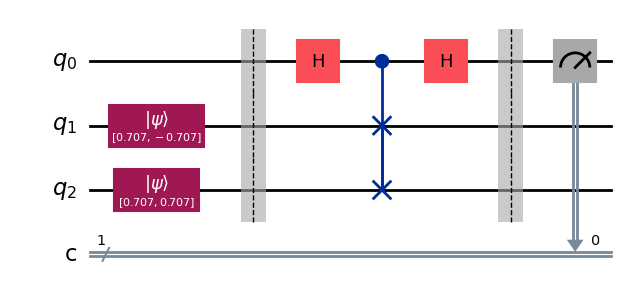

In [1]:
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram
from math import sqrt
import numpy as np

# Set the precision of the print
np.set_printoptions(precision=3)



q = QuantumRegister(3, 'q')
c = ClassicalRegister(1, 'c')

qc = QuantumCircuit(q, c)

psi = Statevector([1/sqrt(2), -1/sqrt(2)])
phi = Statevector([1/sqrt(2), 1/sqrt(2)])
# psi = Statevector([1, 0])
# phi = Statevector([0, 1])

qc.initialize(psi, 1)
qc.initialize(phi, 2)

qc.barrier()
qc.h(0)
qc.cswap(0,1,2)
qc.h(0)
qc.barrier()
qc.measure(0, 0)
qc.draw('mpl')

{'1': 513, '0': 511}


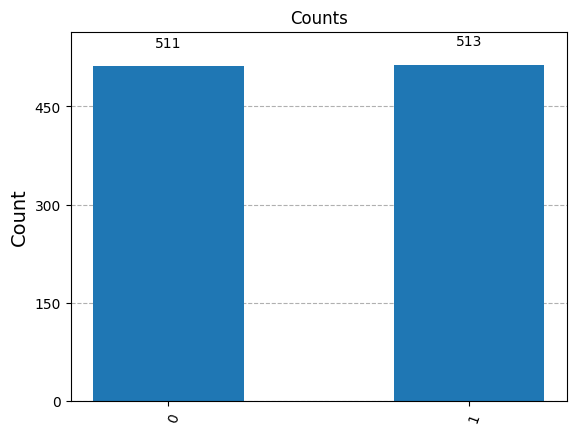

In [2]:

simulator = AerSimulator()
circ = transpile(qc, simulator)

result = simulator.run(circ).result()
counts = result.get_counts(circ)
print(counts)
plot_histogram(counts, title='Counts')




### 2. Build the teleportation circuit

<img src="Image/teleportation1.jpeg" width=600 />


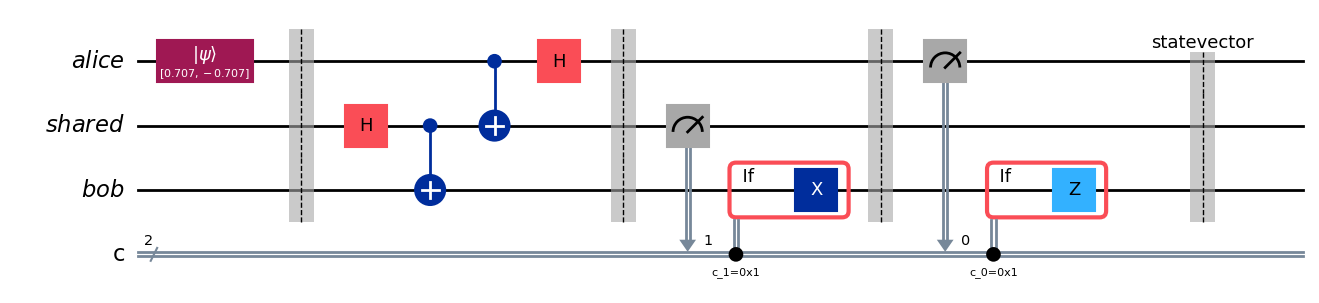

In [3]:

phi = Statevector([1/sqrt(2), -1/sqrt(2)])
# phi = Statevector([1, 0])

a = QuantumRegister(1, 'alice')
s = QuantumRegister(1, 'shared')
b = QuantumRegister(1, 'bob')
c = ClassicalRegister(2, 'c')

teleport_circ = QuantumCircuit(a, s, b, c)

teleport_circ.initialize(phi, a[0])
teleport_circ.barrier()
teleport_circ.h(s)
teleport_circ.cx(s, b)

teleport_circ.cx(a, s)
teleport_circ.h(a)
teleport_circ.barrier()

teleport_circ.measure(s, c[1])
with teleport_circ.if_test((c[1], 1)):
    teleport_circ.x(b)
teleport_circ.barrier()
teleport_circ.measure(a, c[0])
with teleport_circ.if_test((c[0], 1)):
    teleport_circ.z(b)

teleport_circ.save_statevector()
teleport_circ.draw('mpl')


In [4]:
simulator = AerSimulator()
circ = transpile(teleport_circ, simulator)

# Run and get statevector
result = simulator.run(circ).result()
statevector = result.get_statevector(circ)


print(statevector.data)

# Print the statevector in a nice format
s = ""
for i in range(8):
    if statevector.data[i] != 0:
        s += f"{statevector.data[i]:.3f}|{bin(i)[2:].zfill(3)}> + "
print(s[:-3])

[-0.   +0.00e+00j  0.   +0.00e+00j  0.   +0.00e+00j  0.707+0.00e+00j
 -0.   +0.00e+00j -0.   +0.00e+00j  0.   -0.00e+00j -0.707+8.66e-17j]
0.707+0.000j|011> + -0.707+0.000j|111>


#### Deferred Measurement


**Principle of deferred measurement**

Measurements can always be moved from an intermediate stage of a quantum circuit to the end of the circuit.

If the measurement results are used at any stage of the circuit then the *classically controlled operations* can be replaced by *conditional quantum operations*.

---


A consequence of the principle of deferred measurement is that measurement commutes with control.


<img src="Image/DeferredMeasure.png" width=600 />


We use this equivalence in the teleportation circuits


<img src="Image/EqivTelCircuits.png" width=600 />

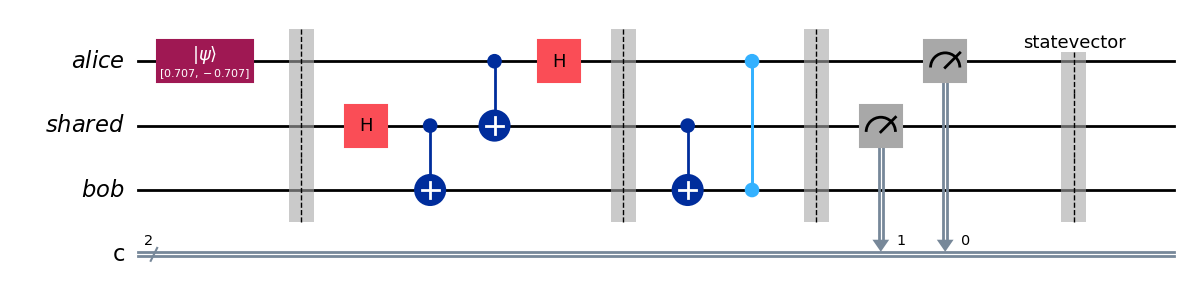

In [5]:

phi = Statevector([1/sqrt(2), -1/sqrt(2)])
# phi = Statevector([1, 0])

a = QuantumRegister(1, 'alice')
s = QuantumRegister(1, 'shared')
b = QuantumRegister(1, 'bob')
c = ClassicalRegister(2, 'c')

teleport_circ = QuantumCircuit(a, s, b, c)

teleport_circ.initialize(phi, a[0])
teleport_circ.barrier()
teleport_circ.h(s)
teleport_circ.cx(s, b)

teleport_circ.cx(a, s)
teleport_circ.h(a)
teleport_circ.barrier()

teleport_circ.cx(s,b)
teleport_circ.cz(a,b)

teleport_circ.barrier()

teleport_circ.measure(s, c[1])
teleport_circ.measure(a, c[0])

teleport_circ.save_statevector()
teleport_circ.draw('mpl')

In [6]:
simulator = AerSimulator()
circ = transpile(teleport_circ, simulator)

# Run and get statevector
result = simulator.run(circ).result()
statevector = result.get_statevector(circ)


print(statevector.data)
s = ""
for i in range(8):
    if statevector.data[i] != 0:
        s += f"{statevector.data[i]:.3f}|{bin(i)[2:].zfill(3)}> + "
print(s[:-3])

[ 0.   +0.00e+00j  0.707+0.00e+00j  0.   +0.00e+00j  0.   +0.00e+00j
 -0.   +0.00e+00j -0.707+8.66e-17j -0.   +0.00e+00j -0.   +0.00e+00j]
0.707+0.000j|001> + -0.707+0.000j|101>


### 3. Verified that it works using the swap test

We can use the swap test to verify better if the teleport circuit works.


In [7]:

def teleport_circuit(teleport_circ, qr, c):
    teleport_circ.h(qr[1])
    teleport_circ.cx(qr[1], qr[2])
    teleport_circ.cx(qr[0], qr[1])
    teleport_circ.h(qr[0])
    teleport_circ.barrier()
    teleport_circ.measure(qr[1], c[1])
    with teleport_circ.if_test((c[1], 1)):
        teleport_circ.x(qr[2])
    teleport_circ.barrier()
    teleport_circ.measure(qr[0], c[0])
    with teleport_circ.if_test((c[0], 1)):
        teleport_circ.z(qr[2])
    
    return teleport_circ

q = QuantumRegister(3)
c = ClassicalRegister(2)
teleport = teleport_circuit(QuantumCircuit(q,c),q,c)
teleport.draw()


┌───┐ ░                                ░ ┌─┐            »
q1_0: ────────────■──┤ H ├─░────────────────────────────────░─┤M├────────────»
      ┌───┐     ┌─┴─┐└───┘ ░ ┌─┐                            ░ └╥┘            »
q1_1: ┤ H ├──■──┤ X ├──────░─┤M├────────────────────────────░──╫─────────────»
      └───┘┌─┴─┐└───┘      ░ └╥┘  ┌──────   ┌───┐ ───────┐  ░  ║   ┌──────   »
q1_2: ─────┤ X ├───────────░──╫───┤ If-0  ──┤ X ├  End-0 ├──░──╫───┤ If-0  ──»
           └───┘           ░  ║   └──╥───   └───┘ ───────┘  ░  ║   └──╥───   »
                              ║ ┌────╨─────┐                   ║ ┌────╨─────┐»
c0: 2/════════════════════════╩═╡ c0_1=0x1 ╞═══════════════════╩═╡ c0_0=0x1 ╞»
                              1 └──────────┘                   0 └──────────┘»
«                     
«q1_0: ───────────────
«                     
«q1_1: ───────────────
«      ┌───┐ ───────┐ 
«q1_2: ┤ Z ├  End-0 ├─
«      └───┘ ───────┘ 
«c0: 2/═══════════════
«

In [8]:
def swap_circuit(qc, q, c):
    qc.h(q[0])
    qc.cswap(q[0],q[1],q[2])
    qc.h(q[0])
    qc.measure(q[0],c)
    return qc

q = QuantumRegister(3)
c = ClassicalRegister(1)
swap = swap_circuit(QuantumCircuit(q, c),q,c)
swap.draw()

┌───┐   ┌───┐┌─┐
q2_0: ┤ H ├─■─┤ H ├┤M├
      └───┘ │ └───┘└╥┘
q2_1: ──────X───────╫─
            │       ║ 
q2_2: ──────X───────╫─
                    ║ 
c1: 1/══════════════╩═
                    0

Now we can put together and add the measurement.
First we initialize the circuit

In [9]:
from qiskit import ClassicalRegister, QuantumRegister


a = QuantumRegister(1, 'alice')
a_test = QuantumRegister(1, 'alice_test')
tel_supp = QuantumRegister(1, 'teleport_supp')
b = QuantumRegister(1, 'bob')
swap_res = QuantumRegister(1, 'swap_result')

garb = ClassicalRegister(2,'garb')
res = ClassicalRegister(1,'res')
qc = QuantumCircuit(a, tel_supp, b, a_test, swap_res, garb, res)

phi = Statevector([0, 1])
qc.initialize(phi, a[0])
qc.initialize(phi,a_test[0])


qc.draw()

┌─────────────────┐
        alice: ┤ Initialize(0,1) ├
               └─────────────────┘
teleport_supp: ───────────────────
                                  
          bob: ───────────────────
               ┌─────────────────┐
   alice_test: ┤ Initialize(0,1) ├
               └─────────────────┘
  swap_result: ───────────────────
                                  
       garb: 2/═══════════════════
                                  
        res: 1/═══════════════════

Here we add the teleport block and the measurement to complete the protocol

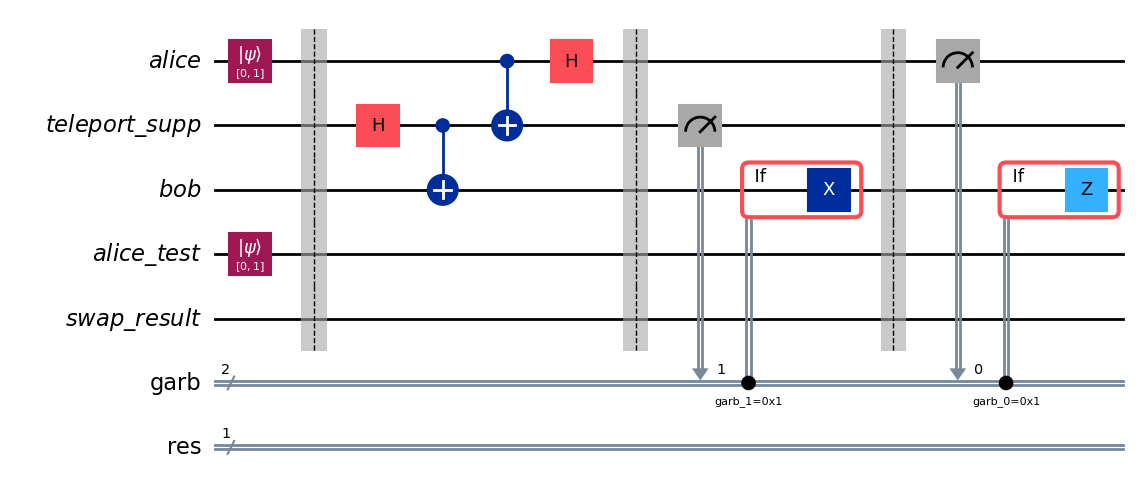

In [10]:
qc.barrier()
qc = teleport_circuit(qc, [a, tel_supp, b], garb)
qc.draw('mpl')

Now we can perform the swap test between the qubit `bob` and `alice_test`, that contains a copy of `alice`

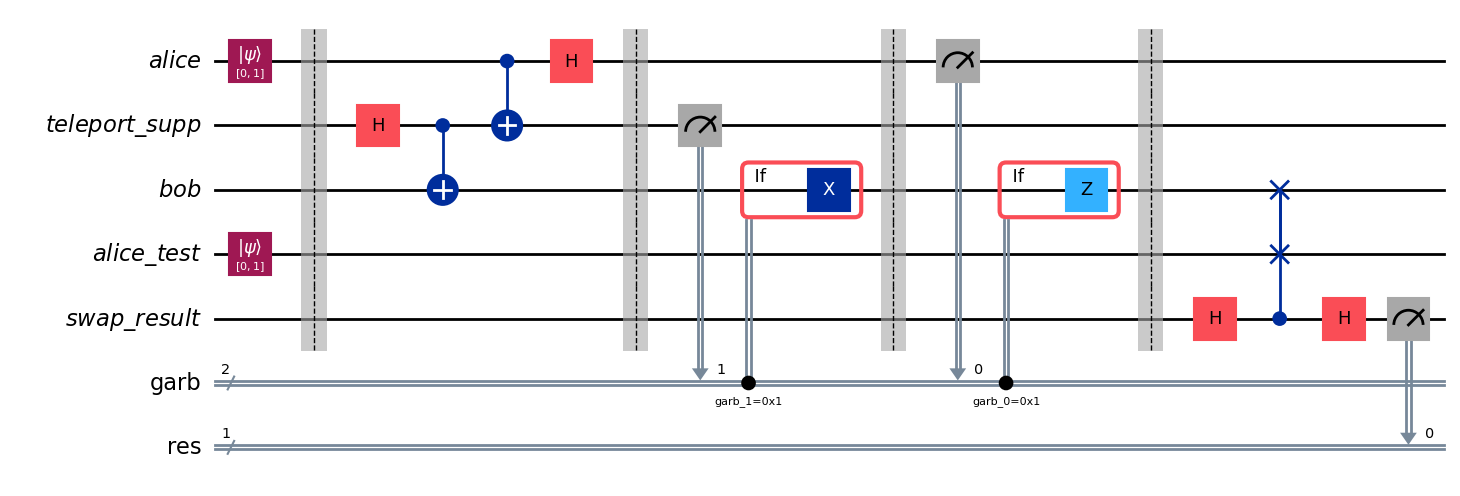

In [11]:
qc.barrier()
qc = swap_circuit(qc, [swap_res, a_test, b], res)
qc.draw('mpl')

Finally, we can simulate the circuit, we see that he first classical big (`res`) is always 0

{'0 11': 240, '0 00': 256, '0 10': 255, '0 01': 273}


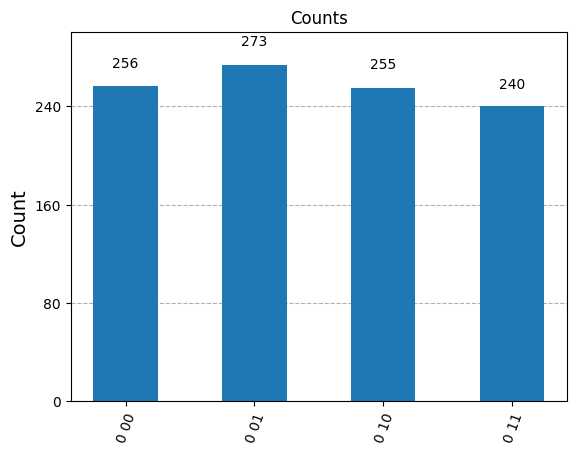

In [12]:
circ = transpile(qc, simulator)

result = simulator.run(circ).result()
counts = result.get_counts(circ)
print(counts)
plot_histogram(counts, title='Counts')

### 3. Phase circuit

There is a bi-univocal correspondence between a generic state of a qubit:

$$
|ψ⟩ = α|0⟩ + β|1⟩,
$$

and a point on the unit sphere in ℝ³ represented as
 
$$
cos(θ/2)|0⟩ + e^{(iϕ)} sin(θ/2)|1⟩, 
$$

where θ and ϕ are real numbers (the spherical coordinates of the point).


<img src="Image/img.png" width=200>

Let's consider this circuit

<img src="Image/thumbnail_Image.png" width=1000 />


$$
|0> \xrightarrow{H} 1/√2(|0⟩ + |1⟩) \xrightarrow{p(2θ)} 1/√2(|0⟩ + e^{(2iθ)}|1⟩) = e^{(iθ)}/√2(e^{(-iθ)}|0⟩ + e^{(iθ)}|1⟩) \xrightarrow{H}  
$$
$$
e^{(iθ)}/2(e^{(-iθ)}(|0⟩ + |1⟩) + e^{(iθ)}(|0⟩ - |1⟩)) = e^{(iθ)}(cosθ|0⟩ - i sinθ|1⟩) \xrightarrow{p(ϕ+π/2)} e^{(iθ)}(cosθ|0⟩ + e^{iϕ} sinθ|1⟩)
$$


In [13]:
from math import pi

theta = pi/3
phi = pi/2

circ = QuantumCircuit(1)
circ.h(0)
circ.p(2*theta, 0)
circ.h(0)
circ.p(phi + pi/2, 0)

print(circ.draw())

Statevector(circ)


   ┌───┐┌─────────┐┌───┐┌──────┐
q: ┤ H ├┤ P(2π/3) ├┤ H ├┤ P(π) ├
   └───┘└─────────┘└───┘└──────┘
Statevector([ 0.25+0.433j, -0.75+0.433j],
            dims=(2,))
